In [1]:
# library import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gensim.downloader
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import keras

2024-12-09 20:04:31.743995: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 20:04:32.809971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 20:04:32.812688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 20:04:33.080581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 20:04:33.432143: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#import data and view shape and first 5 lines
game_reviews = pd.read_csv("reviews_dataset.csv")
print(game_reviews.shape)
game_reviews.head()

(6417106, 5)


,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [3]:
game_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [4]:
game_reviews["app_name"].value_counts()
game_reviews = game_reviews.drop("app_id", axis=1)
game_reviews = game_reviews.drop("app_name", axis=1)
game_reviews = game_reviews.drop("review_votes", axis=1)
game_reviews = game_reviews.dropna(how='any',axis=0)
game_reviews["review_score"].value_counts()

review_score
 1    5254116
-1    1155685
Name: count, dtype: int64

In [ ]:
#Baseline

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X = vectorizer.fit_transform(game_reviews["review_text"])
print(X)

X_train, X_test, y_train, y_test = train_test_split(X, game_reviews['review_score'], test_size=0.3,
                                                    stratify=game_reviews['review_score'], random_state=0)

In [ ]:
model = LinearSVC(random_state=0, tol=1e-5)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_pred, y_test))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Undersampling

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(game_reviews["review_text"]), pd.DataFrame(game_reviews['review_score']))
X = vectorizer.fit_transform(X_resampled["review_text"])

X_train, X_test, y_train, y_test = train_test_split(X, y_resampled['review_score'], test_size=0.3,
                                                    stratify=y_resampled['review_score'], random_state=0)

In [ ]:
model = LinearSVC(random_state=0, tol=1e-5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_pred, y_test))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Undersampling and Semantic

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(game_reviews["review_text"]), pd.DataFrame(game_reviews['review_score']))

resampled = pd.DataFrame()
resampled['review_text'] = X_resampled['review_text']
resampled['review_score'] = y_resampled['review_score']

resampled['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in resampled['review_text']]

porter_stemmer = PorterStemmer()
resampled['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in resampled['tokenized_text'] ]

resampled = resampled[resampled.stemmed_tokens.str.len() > 0]

w2v_model = Word2Vec(resampled["stemmed_tokens"], min_count=1, vector_size=100, window=5)

In [ ]:
review_vectors = []
for row in resampled["stemmed_tokens"]:
    review_vectors.append(w2v_model.wv.get_mean_vector(row))
review_vectors_df = pd.DataFrame(review_vectors)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(review_vectors_df[:], resampled['review_score'], test_size=0.3,
                                                    stratify=resampled['review_score'], random_state=0)
model = LinearSVC(random_state=0, tol=1e-5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_pred, y_test))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Semantic

In [ ]:
game_reviews['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in game_reviews['review_text']]

porter_stemmer = PorterStemmer()
game_reviews['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in game_reviews['tokenized_text'] ]

game_reviews = game_reviews[game_reviews.stemmed_tokens.str.len() > 0]

w2v_model = Word2Vec(game_reviews["stemmed_tokens"], min_count=1, vector_size=100, window=5)

In [ ]:
review_vectors = []
for row in game_reviews["stemmed_tokens"]:
    review_vectors.append(w2v_model.wv.get_mean_vector(row))
review_vectors_df = pd.DataFrame(review_vectors)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(review_vectors_df[:], game_reviews['review_score'], test_size=0.3,
                                                    stratify=game_reviews['review_score'], random_state=0)
model = LinearSVC(random_state=0, tol=1e-5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(metrics.accuracy_score(y_pred, y_test))

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Undersampled and Semantic CNN

In [5]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(game_reviews["review_text"]), pd.DataFrame(game_reviews['review_score']))

resampled = pd.DataFrame()
resampled['review_text'] = X_resampled['review_text']
resampled['review_score'] = y_resampled['review_score']

resampled['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in resampled['review_text']]

porter_stemmer = PorterStemmer()
resampled['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in resampled['tokenized_text'] ]

resampled = resampled[resampled.stemmed_tokens.str.len() > 0]

w2v_model = Word2Vec(resampled["stemmed_tokens"], min_count=1, vector_size=100, window=5)

review_vectors = []
for row in resampled["stemmed_tokens"]:
    review_vectors.append(w2v_model.wv.get_mean_vector(row))
review_vectors_df = pd.DataFrame(review_vectors)
resampled['review_score'] = (resampled['review_score'] + 1)/2

In [6]:
X_train, X_test, y_train, y_test = train_test_split(review_vectors_df[:], resampled['review_score'], test_size=0.3,
                                                    stratify=resampled['review_score'], random_state=0)

25131/25131 [==============================] - 78s 3ms/step - loss: 0.5040 - accuracy: 0.7554 - val_loss: 0.4984 - val_accuracy: 0.7607


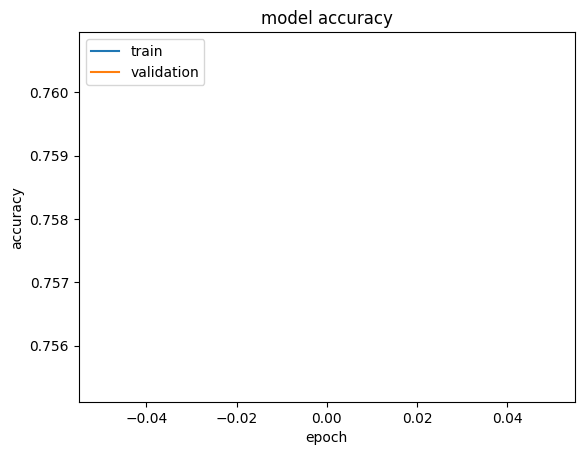

Accuracy: 76.07%


In [9]:
cnn_model = Sequential()
cnn_model.add(Dense(50, activation = "linear"))
cnn_model.add(Dropout(0.3, noise_shape=None, seed=None))
cnn_model.add(Dense(50, activation = "linear"))
cnn_model.add(Dropout(0.2, noise_shape=None, seed=None))
cnn_model.add(Dense(50, activation = "linear"))
cnn_model.add(Dense(1, activation = "sigmoid"))

cnn_model.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=['accuracy'])
history = cnn_model.fit(X_train, y_train, 64,
                    epochs= 15,
                    validation_data= (X_test, y_test))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

scores = cnn_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [11]:
y_pred = cnn_model.predict(X_test)
predicted_classes = np.round(y_pred)

21541/21541 [==============================] - 28s 1ms/step


0.7606857570631469


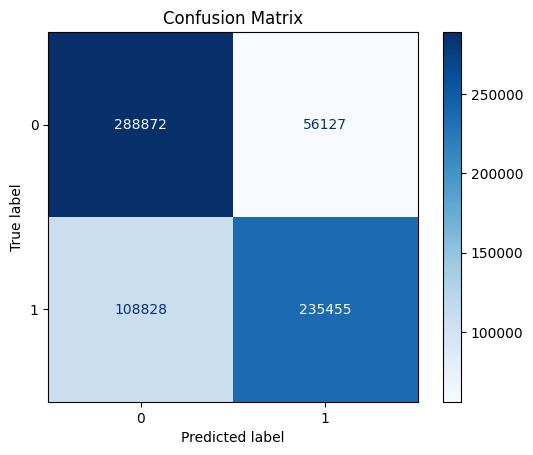

0  
0.0    397700
1.0    291582
Name: count, dtype: int64

In [15]:
print(metrics.accuracy_score(predicted_classes, y_test))

cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [16]:
google_model = gensim.downloader.load('word2vec-google-news-300')

[--------------------------------------------------] 1.7% 28.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 10.3% 170.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 14.1% 233.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========------------------------------------------] 17.9% 297.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========----------------------------------------] 21.5% 357.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 25.3% 420.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============------------------------------------] 28.9% 480.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 32.7% 543.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 35.7% 594.2/1662.8MB downloaded

In [18]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(game_reviews["review_text"]), pd.DataFrame(game_reviews['review_score']))

resampled = pd.DataFrame()
resampled['review_text'] = X_resampled['review_text']
resampled['review_score'] = y_resampled['review_score']

resampled['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in resampled['review_text']]

porter_stemmer = PorterStemmer()
resampled['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in resampled['tokenized_text'] ]

resampled = resampled[resampled.stemmed_tokens.str.len() > 0]

AttributeError: 'KeyedVectors' object has no attribute 'wv'

In [21]:
review_vectors = []
for row in resampled["stemmed_tokens"]:
    review_vectors.append(google_model.get_mean_vector(row))
review_vectors_df = pd.DataFrame(review_vectors)
resampled['review_score'] = (resampled['review_score'] + 1)/2

X_train, X_test, y_train, y_test = train_test_split(review_vectors_df[:], resampled['review_score'], test_size=0.3,
                                                    stratify=resampled['review_score'], random_state=0)

Epoch 1/10
25131/25131 [==============================] - 90s 4ms/step - loss: 0.5299 - accuracy: 0.7240 - val_loss: 0.5062 - val_accuracy: 0.7429
Epoch 2/10
25131/25131 [==============================] - 74s 3ms/step - loss: 0.5162 - accuracy: 0.7336 - val_loss: 0.5035 - val_accuracy: 0.7406
Epoch 3/10
25131/25131 [==============================] - 70s 3ms/step - loss: 0.5121 - accuracy: 0.7360 - val_loss: 0.5174 - val_accuracy: 0.7302
Epoch 4/10
25131/25131 [==============================] - 68s 3ms/step - loss: 0.5099 - accuracy: 0.7384 - val_loss: 0.5026 - val_accuracy: 0.7458
Epoch 5/10
25131/25131 [==============================] - 65s 3ms/step - loss: 0.5082 - accuracy: 0.7393 - val_loss: 0.4940 - val_accuracy: 0.7455
Epoch 6/10
25131/25131 [==============================] - 71s 3ms/step - loss: 0.5072 - accuracy: 0.7403 - val_loss: 0.4935 - val_accuracy: 0.7506
Epoch 7/10
25131/25131 [==============================] - 72s 3ms/step - loss: 0.5061 - accuracy: 0.7408 - val_loss: 0

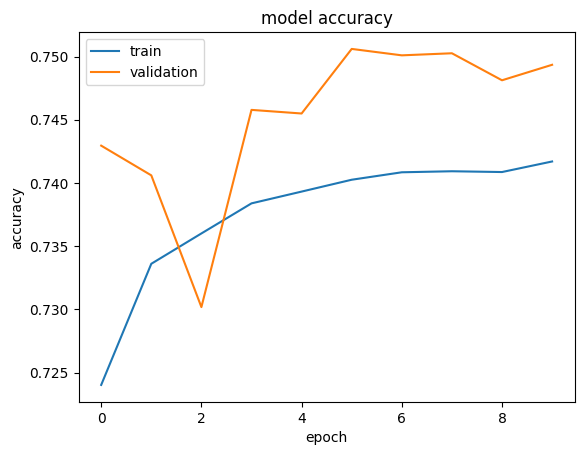

Accuracy: 74.93%


In [24]:
cnn_model = Sequential()
cnn_model.add(Dense(50, activation = "relu"))
cnn_model.add(Dropout(0.3, noise_shape=None, seed=None))
cnn_model.add(Dense(50, activation = "relu"))
cnn_model.add(Dropout(0.2, noise_shape=None, seed=None))
cnn_model.add(Dense(50, activation = "relu"))
cnn_model.add(Dense(1, activation = "sigmoid"))

optimizer = keras.optimizers.Adam(learning_rate=0.01)
cnn_model.compile(loss="binary_crossentropy",
                optimizer=optimizer,
                metrics=['accuracy'])
history = cnn_model.fit(X_train, y_train, 64,
                    epochs= 10,
                    validation_data= (X_test, y_test))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

scores = cnn_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

21541/21541 [==============================] - 23s 1ms/step
0.7645999750464977


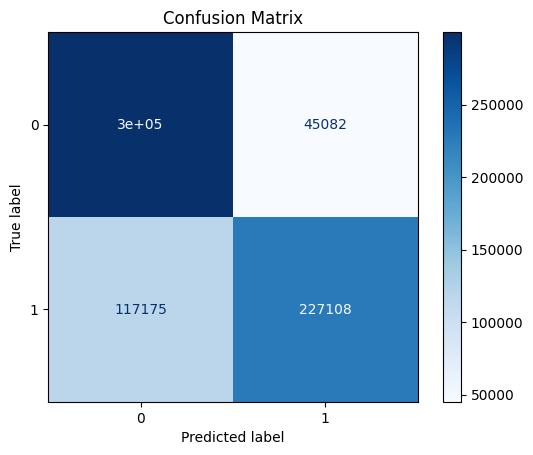

In [23]:
y_pred = cnn_model.predict(X_test)
predicted_classes = np.round(y_pred)

print(metrics.accuracy_score(predicted_classes, y_test))

cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()